In [222]:
import pandas as pd # Importação da biblioteca pandas para leitura dos dados
import numpy as np # Importação da biblioteca np para manipulação de dados
import matplotlib.pyplot as plt




In [223]:
dados_ano=pd.read_csv("dados.txt") # Leitura dos dados de geração e carga de 1 ano

In [224]:
def lerArquivoIEEE(nomeArquivo):
    dadosGerais=[]
    dadosBarras=[]
    dadosRamos=[]
    try:
        file = open(nomeArquivo,'r')
    except OSError:
        return False
    else:
        for linha in file:
            dadosGerais.append(linha[:-1])
        file.close()
    sbase=float(dadosGerais[0][31:36])
    linha=2
    while True:
        apenasNumeros=dadosGerais[linha][:5]+dadosGerais[linha][17:]
        dadosBarras.append(apenasNumeros.split())
        linha+=1
        if dadosGerais[linha][:4]=='-999' or linha>=len(dadosGerais):
            break
    linha+=2
    while True:
        dadosRamos.append(dadosGerais[linha].split())
        linha+=1
        if dadosGerais[linha][:4]=='-999' or linha>=len(dadosGerais):
            break
    nb=len(dadosBarras)
    dadosBarras=np.array(dadosBarras,dtype=np.float64)
    dadosRamos=np.array(dadosRamos,dtype=np.float64)
    dfBarras=pd.DataFrame(dadosBarras,columns=['bus','area','zone','type','voltage',
											'angle','pl','ql','pg','qg',
											'base_voltage','desired_volts','q_max','q_min',
											'g_shunt','b_shunt','control_bus'])
    dfRamos=pd.DataFrame(dadosRamos,columns=['from','to','area','zone','circuit','type','resistance',
											'reactance','charging_b','rating_1','rating_2','rating_3',
											'control_bus','side','tap','trans_phase','tap_min','tap_max',
											'step_size','volt_min','volt_max'])
    dfRamos['tap']=dfRamos['tap'].replace(0.0, 1.0)
    dfRamos['from']=[np.where(dfBarras['bus'] == i)[0][0] for i in dfRamos['from']]
    dfRamos['to']=[np.where(dfBarras['bus'] == i)[0][0] for i in dfRamos['to']]
    dfBarras=dfBarras.drop('bus', axis=1)
    return (nb, #Numero de barras
        sbase, # S base
        dfBarras,
        dfRamos) 

In [225]:
def geracao_solar(dados_ano):
    # Defiições do painel fotovoltaico utilizado
    # Painel Himalaya G12 Huasun 715 W	210mm	N-Type HC Bifacial MBB	23.0 %
    n_PV = 0.23
    n_conv = 0.9
    area_painel = 3.12
    numero_paineis = 10000 #equivale a 7.15 MW instalados
    # Geração fotovoltaica
    Pot_PV = dados_ano.radiacao * n_PV * n_conv * area_painel * numero_paineis
    Pot_PV = np.array(Pot_PV)
    return Pot_PV

In [226]:
def geracao_eolica(dados_ano):
    # Definições para ajuste  de velocidade do vento # Turbina Eólica Generica do Homer Pro 1.5MW
    # Dados de vento medidos a 2m de altura
    H0 = 2
    H = 80    # Altura da nacele aerogerador
    Fator_rugosidade = 0.23
    vento_corrigido = dados_ano.vento * (H / H0) ** Fator_rugosidade

    # Definições do aerogerador utilizado
    Pot_max_GE = 1500000 #W
    Vc = 4.0
    Vf = 25
    Vr = 14
    numero_aerogeradores = 10 #equivale a 15 MW instalados
    
    # Geração eólica
    Pot_GE = np.zeros(len(vento_corrigido))
    index = set(dados_ano.index[vento_corrigido >= Vc].tolist()) & set(dados_ano.index[vento_corrigido <= Vr].tolist())
    Pot_GE[list(index)] = Pot_max_GE * ((vento_corrigido[list(index)] - Vc) / (Vr - Vc)) * numero_aerogeradores
    index = set(dados_ano.index[vento_corrigido >= Vr].tolist()) & set(dados_ano.index[vento_corrigido <= Vf].tolist())
    Pot_GE[list(index)] = Pot_max_GE * numero_aerogeradores
    return Pot_GE

In [227]:
Pot_PV = geracao_solar(dados_ano)
print(max(Pot_PV))

7536055.7992824


In [228]:
Pot_GE = geracao_eolica(dados_ano)
pot_media_ge = 0
for i in range(0,8760):
    pot_media_ge = Pot_GE[i] + pot_media_ge
pot_media_ge = pot_media_ge/8760

print(pot_media_ge)


Pot_PV = geracao_solar(dados_ano)
pot_media_PV = 0
for i in range(0,8760):
    pot_media_PV = Pot_PV[i] + pot_media_PV
pot_media_PV = pot_media_PV/8760

print(pot_media_PV)

pot_media_dem=0
for i in range(0,8760):
    pot_media_dem = dados_ano.demanda[i] + pot_media_dem
pot_media_dem = pot_media_dem/8760

print(pot_media_dem)

mult_carga = (pot_media_ge+pot_media_PV)/pot_media_dem
print(mult_carga)

6450975.274977567
1418195.2760987566
2727.366801369867
2885.263011606615


In [229]:
carga = np.array(dados_ano.demanda)
print(max(carga))

5431.86


In [230]:
def cal_net_load(dados_ano):
    # Carga da rede
    carga = np.array(dados_ano.demanda)
    net_load = np.zeros(len(dados_ano.hora))
    net_load = geracao_eolica(dados_ano) + geracao_solar(dados_ano) - carga*1000
    return net_load

In [231]:
def funcionamento_bateria(net_load, BESS_energy, soc_min, soc_max, soc_int, dados_ano): # Soe = State of Energy
    soe= np.zeros(len(dados_ano.hora))
    soe_min = soc_min * BESS_energy
    soe_max = soc_max * BESS_energy
    soe_int = soc_int * BESS_energy
    soe[0] = soe_int
    loss = 0
    lpsp = 0
    for i in range(len(dados_ano.hora)-1): 
        if soe[i] >= soe_min and soe[i] <= soe_max:
            soe[i+1] = soe[i] + (net_load[i]+net_load[i+1])/2
            if soe[i+1] > soe_max:
                soe[i+1] = soe_max
            elif soe[i+1] < soe_min:
                soe[i+1] = soe_min
                loss = (net_load[i]+net_load[i+1])/2 - (soe[i]-soe_min)
        else:
            print('erro')
        lpsp=lpsp+abs(loss)
    lpsl=lpsp/(sum(dados_ano.demanda)*len(dados_ano.demanda))
    print(lpsl)
    return lpsl

In [232]:
def enxame_inicial(N_pop, limites, dim):
    BESS_energy = np.zeros((N_pop, dim))
    for i in range(N_pop):
        for j in range(dim):
            BESS_energy[i,j] = np.random.uniform(limites[0], limites[1])
    return BESS_energy

In [233]:
#Avalia o custo da posicao avaliada
def calcula_custo_bess(net_load, BESS_energy, soc_min, soc_max, soc_int, dados_ano, lpsl_max):
    lpsl = funcionamento_bateria(net_load, BESS_energy, soc_min, soc_max, soc_int, dados_ano)
    if lpsl > lpsl_max:
        custo_bess = BESS_energy+lpsl*100000000
    else:
        custo_bess = BESS_energy
    return custo_bess

In [234]:
#Input dos Dados
soc_min=0.1
soc_max=0.9
soc_int=0.9
lpsl_max = 0.04

tol = 1e-6
kmax = 10
K_run=20
N_pop=30

w = 0.5                   
c1 = 2.0                  
c2 = 2.0                  

dim = 1                     
max_iter = 100             
limites = (0, 10000000)
x_min = limites[0]
x_max = limites[1]
iterMax = 20

p_val = np.zeros(N_pop)

p_best_val = np.zeros(N_pop)        
g_best_val = np.zeros(1)          

p_best = np.zeros((N_pop,dim))      
g_best = np.zeros(dim)     

BESS_energy = enxame_inicial(N_pop, limites, dim)
net_load = cal_net_load(dados_ano)

for ii in range(N_pop):
    p_best_val[ii] = calcula_custo_bess(net_load, BESS_energy[ii], soc_min, soc_max, soc_int, dados_ano, lpsl_max)
    p_best [ii] = BESS_energy[ii]

ind = np.argmin(p_best_val)                      
g_best_val = np.copy(p_best_val[ind]) 
g_best = np.copy(p_best[ind,:])  

v = np.zeros((N_pop,dim))  

x=BESS_energy

for iter in range(iterMax):
    rp = np.random.rand(dim,N_pop)         
    rg = np.random.rand(dim,N_pop)           
    
    y=g_best.reshape(1,len(g_best))
    z=p_best.reshape(dim,len(p_best))

    v_global = np.multiply(((x-y)),rg.transpose())*c2*(-1.0)    
    v_local = np.multiply((z.T- x),rp.T)*c1          
    
    v = w*v + (v_local + v_global)       

    for ii in range(N_pop):
        for jj in range(dim):
            if v[ii,jj] > x_max - x[ii,jj]:
                v[ii,jj] = x_max - x[ii,jj]
                continue
            elif v[ii,jj] < x_min - x[ii,jj]:
                v[ii,jj] = x_min - x[ii,jj]
    x = x + v

    x=np.round(x).astype(int)

    for ii in range(N_pop):
        p_val[ii] = calcula_custo_bess(net_load, BESS_energy[ii], soc_min, soc_max, soc_int, dados_ano, lpsl_max)
        if p_val[ii] < p_best_val[ii]:
            p_best_val[ii] = p_val[ii]
            p_best [ii] = x[ii]

    ind = np.argmin(p_best_val)                      
    g_best_val = np.copy(p_best_val[ind]) 
    g_best = np.copy(p_best[ind,:])  


print(g_best_val)
print(g_best)

[0.04648366]
[0.05507419]
[0.05374314]
[0.04877383]
[0.04795644]
[0.0430284]
[0.04796944]
[0.05027462]
[0.05535449]
[0.04800876]
[0.04626853]
[0.05979413]
[0.05599676]
[0.04692047]
[0.04628391]
[0.04878281]
[0.04335781]
[0.04295808]
[0.05027752]
[0.05583891]
[0.04643979]
[0.04938356]
[0.04890213]
[0.05998727]
[0.04766169]
[0.04925742]
[0.05634518]
[0.04714285]
[0.06125389]
[0.06047278]
[0.04648366]
[0.05507419]
[0.05374314]
[0.04877383]
[0.04795644]
[0.0430284]
[0.04796944]
[0.05027462]
[0.05535449]
[0.04800876]
[0.04626853]
[0.05979413]
[0.05599676]
[0.04692047]
[0.04628391]
[0.04878281]
[0.04335781]
[0.04295808]
[0.05027752]
[0.05583891]
[0.04643979]
[0.04938356]
[0.04890213]
[0.05998727]
[0.04766169]
[0.04925742]
[0.05634518]
[0.04714285]
[0.06125389]
[0.06047278]
[0.04648366]
[0.05507419]
[0.05374314]
[0.04877383]
[0.04795644]
[0.0430284]
[0.04796944]
[0.05027462]
[0.05535449]
[0.04800876]
[0.04626853]
[0.05979413]
[0.05599676]
[0.04692047]
[0.04628391]
[0.04878281]
[0.04335781]
[0

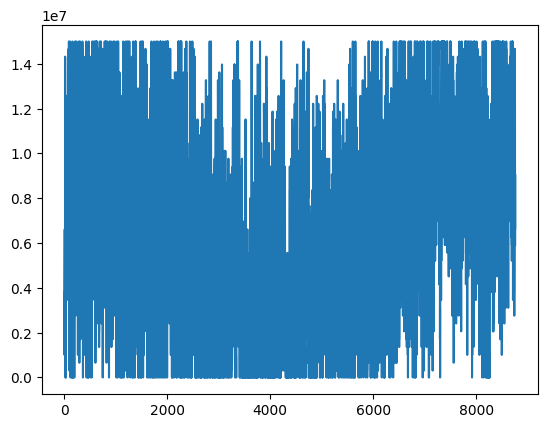

<Figure size 640x480 with 0 Axes>

In [235]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
x = list(np.arange(0,8760))
# corresponding y axis values
y = geracao_solar(dados_ano)

z = geracao_eolica(dados_ano)

p = cal_net_load(dados_ano)

l = dados_ano.demanda

# plotting the points
# plt.plot(x, y)
plt.plot(x, z)
# plt.plot(x, p)
#plt.plot(x, l)
# function to show the plot
plt.show()
plt.savefig('filename.png', dpi=500)
